In [46]:
data_path = "../data/annotated_data"
save_model_dir_name = "best_model_distilbert"
# set to true if colab!
colab = False
train_model = False
if colab:
    data_path = '/content/drive/MyDrive/annotated_data'
    !pip install transformers
    !pip install evaluate
    !pip install seaborn
    !pip install accelerate
    try:
        from google.colab import drive
        drive.mount('/content/drive', force_remount=True)
    except:
        print("probably not in colab")

# Imports

In [47]:
import os
import ast
import json
import torch
torch.manual_seed(0)
import random
random.seed(0)
import itertools
import numpy as np
np.random.seed(0)
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme()
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix
from transformers import AutoTokenizer, DistilBertForSequenceClassification,get_scheduler
from sklearn import preprocessing
from tqdm.auto import tqdm
from experiment_utils import EarlyStopper
from sklearn.metrics import accuracy_score, classification_report

# Load Data

In [48]:
files = [f for f in os.listdir(data_path) if f.endswith('jsonl')]
rows = []

In [49]:
for f in files:
    with open(f'{data_path}/{f}', 'r') as json_file:
        json_list = list(json_file)
    for json_str in json_list:
        result = json.loads(json_str)
        label = result["label"]
        text = result["text"]
        new_spans = []
        if result["spans"] and len(result["spans"]) != 0:
            try:
                new_spans = [s["text"] for s in result["spans"]]
            except:
                x = ast.literal_eval(result["spans"])
                new_spans = [s["text"] for s in x]
        new_row = {
            "text":text,
            "label":label,
            "spans":new_spans
        }
        rows.append(new_row)
    print(f"Loaded: {f}")
df = pd.DataFrame(rows)

Loaded: 3d_printed_clothes_sentences.jsonl
Loaded: cement_production_sentences.jsonl
Loaded: organic_food_sentences.jsonl
Loaded: shipping_sentences.jsonl
Loaded: sustainable_fabrics_sentences.jsonl
Loaded: artificial_intelligence_sentences.jsonl
Loaded: clothes_designed_for_a_circular_economy_sentences.jsonl
Loaded: autonomous_transport_sentences.jsonl
Loaded: fiber_optic_cables_sentences.jsonl
Loaded: electric_car_sentences.jsonl
Loaded: drone_sentences.jsonl
Loaded: e_health_sentences.jsonl
Loaded: capsule_wardrobe_sentences.jsonl
Loaded: car_sharing_sentences.jsonl
Loaded: smart_food_management_kitchen_fridges_freezers_sentences.jsonl
Loaded: biking_sentences.jsonl
Loaded: rent_apparel_sentences.jsonl


## Inspecting the data

Text(0.5, 1.0, 'number of examples per class')

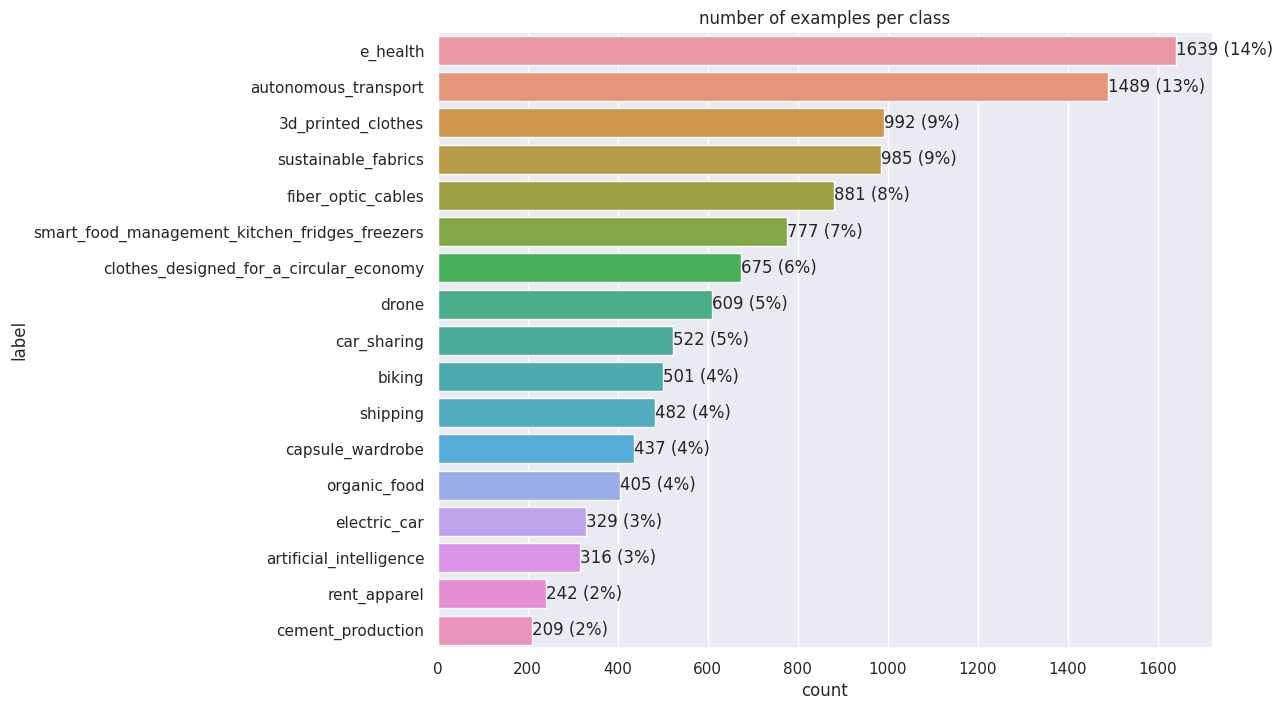

In [50]:
plt.figure(figsize=(10,8))

abs_values = df['label'].value_counts(ascending=False)
g = sns.countplot(data=df, y="label", order=abs_values.index)
rel_values = df['label'].value_counts(ascending=False, normalize=True).values * 100
bar_labels = [f'{p[0]} ({p[1]:.0f}%)' for p in zip(abs_values.values, rel_values)]
g.bar_label(container=g.containers[0], labels=bar_labels)
g.set_title("number of examples per class")

text length statistics


,mean,median,min,max
label,,,,
3d_printed_clothes,383.121976,380.5,57,1054
artificial_intelligence,470.534810,458.0,184,952
autonomous_transport,415.642042,403.0,14,2315
biking,419.335329,409.0,112,1187
capsule_wardrobe,358.945080,321.0,73,1189
car_sharing,318.021073,311.0,16,848
cement_production,450.602871,439.0,35,1119
clothes_designed_for_a_circular_economy,432.047407,414.0,123,1195
drone,410.180624,412.0,16,1655


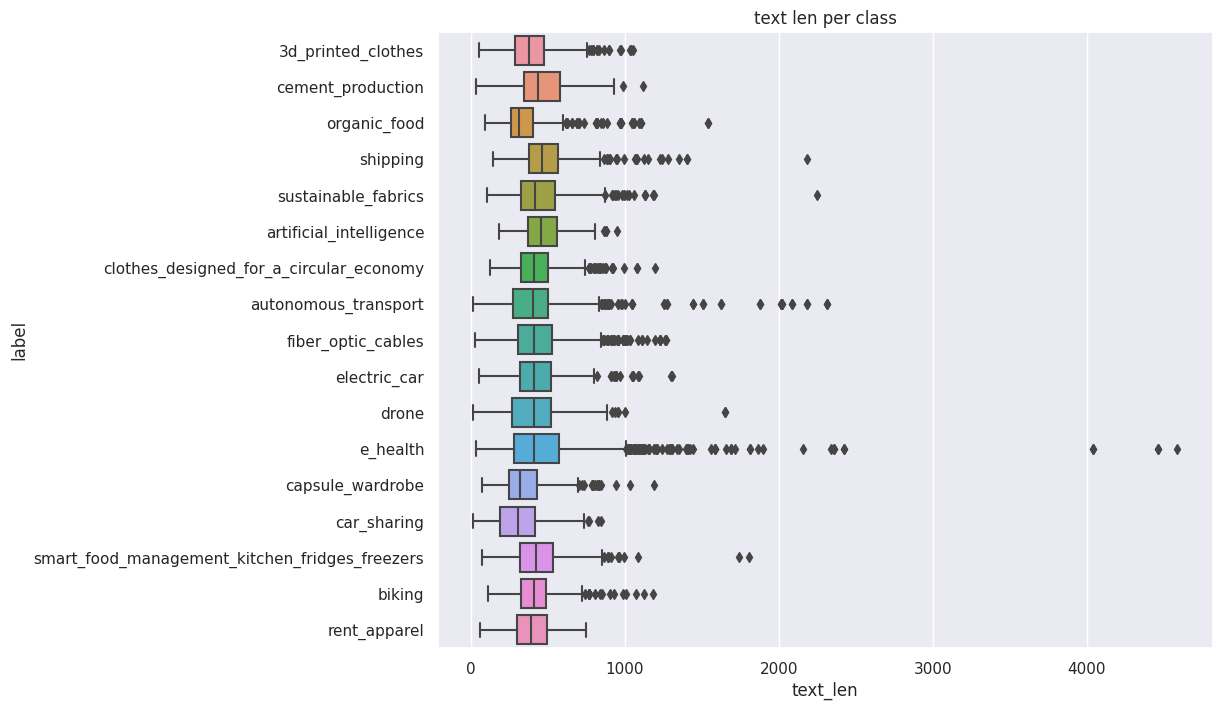

In [51]:
df["text_len"] = df[["text"]].apply(lambda x:len(x.item()), axis=1)
plt.figure(figsize=(10,8))
g = sns.boxplot(data=df, x="text_len", y="label")
g.set_title("text len per class")
print("text length statistics")
df.groupby(["label"])["text_len"].agg(["mean","median","min","max"])

# Data Preparation
## Encode Labels

In [52]:
le = preprocessing.LabelEncoder()
df["label_encoded"] = le.fit_transform(df["label"])

## Train, Valdiation and Test Split

In [53]:
# 70, 20, 10 split
train_df, val_df, test_df = np.split(df.sample(frac=1), [int(.7*len(df)), int(.9*len(df))])
train_df.reset_index(inplace=True)
val_df.reset_index(inplace=True)
test_df.reset_index(inplace=True)

In [54]:
# collect spans from the training data-set
new_spans = set(itertools.chain.from_iterable(train_df.spans.tolist()))

# Create Datasets and Tokenize

In [55]:
# add new spans to the tokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased", do_lower_case=False)
# extend tokenizer with domain spans
new_tokens = set(new_spans) - set(tokenizer.vocab.keys())
tokenizer.add_tokens(list(new_tokens))

244

In [56]:
# define PyTorch dataset
class TAndIDataSet(Dataset):
    def __init__(self, text_column, encoded_labels):
        self.texts = text_column
        self.encodings = tokenizer(text_column.tolist(), truncation=True, padding=True, max_length=512)
        self.labels = encoded_labels

    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item["labels"] = torch.tensor([self.labels[idx]])
        return item, self.texts[idx]

    def __len__(self):
        return len(self.labels)

In [57]:
# create datasets
train_dataset = TAndIDataSet(train_df.text, train_df.label_encoded)
val_dataset = TAndIDataSet(val_df.text, val_df.label_encoded)
test_dataset = TAndIDataSet(test_df.text, test_df.label_encoded)
# create dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=16)
val_dataloader = DataLoader(val_dataset, batch_size=32)
test_dataloader =  DataLoader(test_dataset, batch_size=32)

# Finetuning
## Definitions

In [58]:
if train_model:
    # model definition
    model = DistilBertForSequenceClassification.from_pretrained(
        "distilbert-base-uncased",
        num_labels=len(le.classes_)
    ).to("cuda")
    # adjust embeddings size for new vocabulary length
    model.resize_token_embeddings(len(tokenizer))
else:
    tokenizer = AutoTokenizer.from_pretrained(f"./model_checkpoints/{save_model_dir_name}", local_files_only=True)
    model = DistilBertForSequenceClassification.from_pretrained(f"./model_checkpoints/{save_model_dir_name}", local_files_only=True).to("cuda")

In [59]:
# optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
# epochs
num_epochs = 20
# learning rate scheduler
lr_scheduler = get_scheduler(
    name="linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_epochs * len(train_dataloader)
)

## Training Loop

In [60]:
if train_model:
    training_stats = []
    progress_bar = tqdm(range(num_epochs*(len(train_dataloader)+len(val_dataloader))))
    early_stopper = EarlyStopper(patience=5)
    best_val_loss = np.Inf
    for epoch in range(num_epochs):
        print(f"\nRunning Epoch {epoch+1}/{num_epochs}...")
        epoch_train_losses = []
        epoch_val_losses = []
        epoch_train_correct = 0
        epoch_val_correct = 0
        # training loop
        model.train()
        for batch, _ in train_dataloader:
            # move batch to gpu
            batch = {k: v.to("cuda") for k, v in batch.items()}
            # forward pass
            output = model(**batch)
            predictions = torch.argmax(output.logits, dim=-1)
            epoch_train_correct += (predictions == batch["labels"].flatten()).long().sum()
            # compute loss & backprop
            loss = output.loss
            loss.backward()
            optimizer.step()
            lr_scheduler.step()
            # reset optimizer
            optimizer.zero_grad()
            # save batch_loss
            epoch_train_losses.append(loss.item())
            progress_bar.update(1)
        # validation loop
        model.eval()
        for batch, _ in val_dataloader:
            batch = {k: v.to("cuda") for k, v in batch.items()}
            with torch.no_grad():
                output = model(**batch, output_attentions=True, output_hidden_states=True)
                predictions = torch.argmax(output.logits, dim=-1)
                epoch_val_correct += (predictions == batch["labels"].flatten()).long().sum()
                epoch_val_losses.append(output.loss.item())
            progress_bar.update(1)
        # save epoch metrics
        mean_epoch_val_loss = np.mean(epoch_val_losses)
        epoch_stats = {
            "epoch":epoch,
            "train_loss":np.mean(epoch_train_losses),
            "val_loss":mean_epoch_val_loss,
            "train_accuracy":epoch_train_correct.item()/len(train_dataset),
            "val_accuracy":epoch_val_correct.item()/len(val_dataset)
        }
        print(epoch_stats)
        training_stats.append(epoch_stats)
        # save best model
        if mean_epoch_val_loss < best_val_loss:
            model_path = f"./{save_model_dir_name}"
            model.save_pretrained(model_path)
            tokenizer.save_pretrained(model_path)
            best_val_loss = mean_epoch_val_loss

        if early_stopper.early_stop(mean_epoch_val_loss):
            print("Stopping early")
            break

    # if colab make sure to save best model to google drive
    training_stats = pd.DataFrame(training_stats)
    if colab:
        !cp -r $save_model_dir_name /content/drive/MyDrive
else:
    print("training disabled")

training disabled


In [61]:
if train_model:
    plt.figure(figsize=(8,8))
    sns.lineplot(
        data=training_stats[["epoch","train_loss","val_loss"]].melt(id_vars=["epoch"]),
        x="epoch",
        y="value",
        hue="variable"
    )

In [62]:
if train_model:
    plt.figure(figsize=(8,8))
    sns.lineplot(
        data=training_stats[["epoch","train_accuracy","val_accuracy"]].melt(id_vars=["epoch"]),
        x="epoch",
        y="value",
        hue="variable"
    )

# Testing

In [63]:
progress_bar = tqdm(range(len(test_dataloader)))
test_correct = 0
test_predictions = []
model.eval()
softmax = torch.nn.Softmax(dim=len(le.classes_))
for batch, texts in test_dataloader:
    batch = {k: v.to("cuda") for k, v in batch.items()}
    with torch.no_grad():
        output = model(**batch)
        local_predictions = torch.argmax(output.logits, dim=-1)
        top_k_predictions = torch.topk(output.logits, k=3)
        test_correct += (local_predictions == batch["labels"].flatten()).long().sum()
        for idx, pred in enumerate(local_predictions.tolist()):
            test_predictions.append({
                "y_hat_enc":pred,
                "y_enc":batch["labels"].flatten().tolist()[idx],
                "text":texts[idx],
                "top_k":top_k_predictions.indices[idx].tolist(),
                "top_k_logits": top_k_predictions.values[idx].tolist(),
                "in_top_k":batch["labels"].flatten().tolist()[idx] in top_k_predictions.indices[idx].tolist()
            })
    progress_bar.update(1)
print(f"Test Accuracy: {test_correct/(len(test_dataloader)*test_dataloader.batch_size)}")
test_predictions = pd.DataFrame(test_predictions)
test_predictions["y"] = le.inverse_transform(test_predictions["y_enc"])
test_predictions["y_hat"] = le.inverse_transform(test_predictions["y_hat_enc"])
print(f"Test top-k Accuracy: {len(test_predictions.loc[test_predictions.in_top_k])/(len(test_dataloader)*test_dataloader.batch_size)}")

  0%|          | 0/36 [00:00<?, ?it/s]

Test Accuracy: 0.9548611044883728
Test top-k Accuracy: 0.9835069444444444


## Wrong classifications

In [64]:
test_predictions.loc[test_predictions.y_enc != test_predictions.y_hat_enc].head(n=1000)

,y_hat_enc,y_enc,text,top_k,top_k_logits,in_top_k,y,y_hat
28,2,9,Only a minority of late potential users [19] h...,"[2, 9, 5]","[2.213348150253296, 1.432673692703247, 0.26478...",True,e_health,autonomous_transport
41,2,11,"21. Also, theoretical output, which is based o...","[2, 11, 5]","[5.194251537322998, 3.111764669418335, 0.64404...",True,fiber_optic_cables,autonomous_transport
89,14,16,"However, many brands don’t, and that’s where t...","[14, 16, 8]","[1.5766633749008179, 0.7102270126342773, 0.695...",True,sustainable_fabrics,shipping
123,13,7,thredUP sells used clothes from well-known bra...,"[13, 7, 0]","[6.392207622528076, 2.9557840824127197, 0.9400...",True,clothes_designed_for_a_circular_economy,rent_apparel
137,5,15,"Log in\nJoin a growing community of 350,000+ S...","[5, 10, 11]","[5.194408893585205, 0.36774304509162903, -0.60...",False,smart_food_management_kitchen_fridges_freezers,car_sharing
157,7,16,But I also think Orange Fiber [Ed note: A mate...,"[7, 16, 0]","[8.016777992248535, 4.576661109924316, -0.9724...",True,sustainable_fabrics,clothes_designed_for_a_circular_economy
187,9,10,Virtual Fixit Clinic\nAs COVID-19 unfolds Fixi...,"[9, 15, 11]","[7.86639928817749, 1.609594464302063, -1.21798...",False,electric_car,e_health
202,3,5,"Life happens, and you or your carpool driver m...","[3, 13, 5]","[4.7105255126953125, 1.7354035377502441, 0.155...",True,car_sharing,biking
214,5,2,"Référence électronique\nLaura Brimont, Mathieu...","[5, 2, 3]","[5.783801555633545, 4.167691707611084, 0.59457...",True,autonomous_transport,car_sharing
221,9,2,Excellent statistical results of current AI me...,"[9, 2, 15]","[5.786809921264648, 2.4561944007873535, 2.0405...",True,autonomous_transport,e_health


In [65]:
print("num. miss-classifications per class")
test_predictions.loc[test_predictions.y_enc != test_predictions.y_hat_enc].groupby(["y"])["y"].count()

num. miss-classifications per class


y
3d_printed_clothes                                 2
autonomous_transport                               5
capsule_wardrobe                                   2
car_sharing                                       10
cement_production                                  1
clothes_designed_for_a_circular_economy            5
e_health                                           6
electric_car                                       2
fiber_optic_cables                                 3
rent_apparel                                       1
shipping                                           2
smart_food_management_kitchen_fridges_freezers     3
sustainable_fabrics                                7
Name: y, dtype: int64

### Confusion Matrix

0 : 3d_printed_clothes
1 : artificial_intelligence
2 : autonomous_transport
3 : biking
4 : capsule_wardrobe
5 : car_sharing
6 : cement_production
7 : clothes_designed_for_a_circular_economy
8 : drone
9 : e_health
10 : electric_car
11 : fiber_optic_cables
12 : organic_food
13 : rent_apparel
14 : shipping
15 : smart_food_management_kitchen_fridges_freezers
16 : sustainable_fabrics
                                                precision    recall  f1-score   support

                            3d_printed_clothes       0.97      0.98      0.97        93
                       artificial_intelligence       0.97      1.00      0.99        36
                          autonomous_transport       0.95      0.97      0.96       144
                                        biking       0.89      1.00      0.94        50
                              capsule_wardrobe       0.96      0.96      0.96        49
                                   car_sharing       0.84      0.76      0.80        42
 

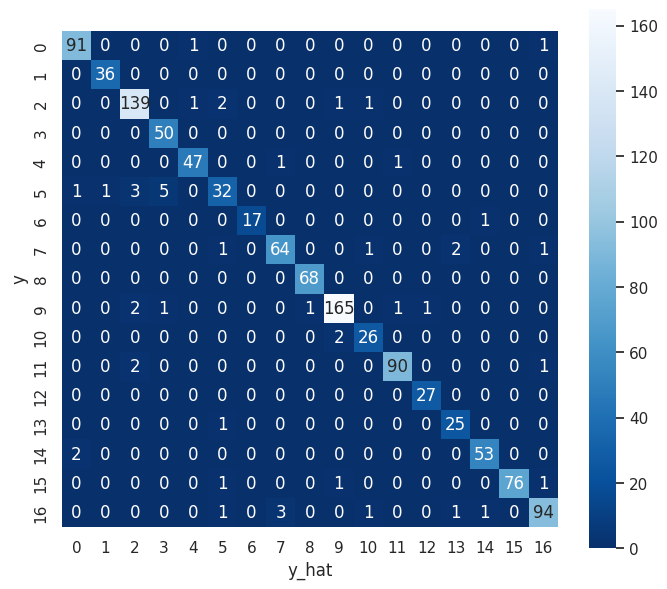

In [72]:
# axis_ticks = le.inverse_transform(list(range(0,17)))
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
for key,value in le_name_mapping.items():
    print(f"{value} : {key}")
cm = confusion_matrix(test_predictions["y_enc"],test_predictions["y_hat_enc"])
plt.figure(figsize=(8,7))
g = sns.heatmap(cm, annot=True, fmt='g', square = True, cmap = 'Blues_r')
g.set_ylabel("y")
g.set_xlabel("y_hat")
print(classification_report(test_predictions["y_enc"],test_predictions["y_hat_enc"], target_names=le.classes_))
print("Accuracy score: ", accuracy_score(test_predictions["y_enc"],test_predictions["y_hat_enc"]))
per_class_accuracy = cm.diagonal()/cm.sum(axis=1)
print("per class accuracy:", per_class_accuracy)


### Detailed inspection of miss-classifications

In [67]:
# class of interest
coi = "electric_car"
coi_miss = test_predictions.loc[(test_predictions.y==coi) & (test_predictions.y_hat != coi)]
print(f"Total num. miss: {len(coi_miss)}, non-top-k miss: {len(coi_miss.loc[~coi_miss.in_top_k])}")
coi_miss_enhanced = []
for idx, row in coi_miss.iterrows():
    for tk in range(len(row.top_k)):
        new_row = {
            "score": row.top_k_logits[tk],
            "y_hat_enc": row.top_k[tk],
            "y_hat": le.inverse_transform([row.top_k[tk]])[0],
            "rank":str(tk)
        }
        coi_miss_enhanced.append(new_row)
coi_miss_enhanced = pd.DataFrame(coi_miss_enhanced)
coi_miss

Total num. miss: 2, non-top-k miss: 2


,y_hat_enc,y_enc,text,top_k,top_k_logits,in_top_k,y,y_hat
187,9,10,Virtual Fixit Clinic\nAs COVID-19 unfolds Fixi...,"[9, 15, 11]","[7.86639928817749, 1.609594464302063, -1.21798...",False,electric_car,e_health
820,9,10,"Do something for our planet, print this page o...","[9, 7, 16]","[1.909122347831726, 1.7857515811920166, -0.099...",False,electric_car,e_health


rank 0 should be 'electric_car'


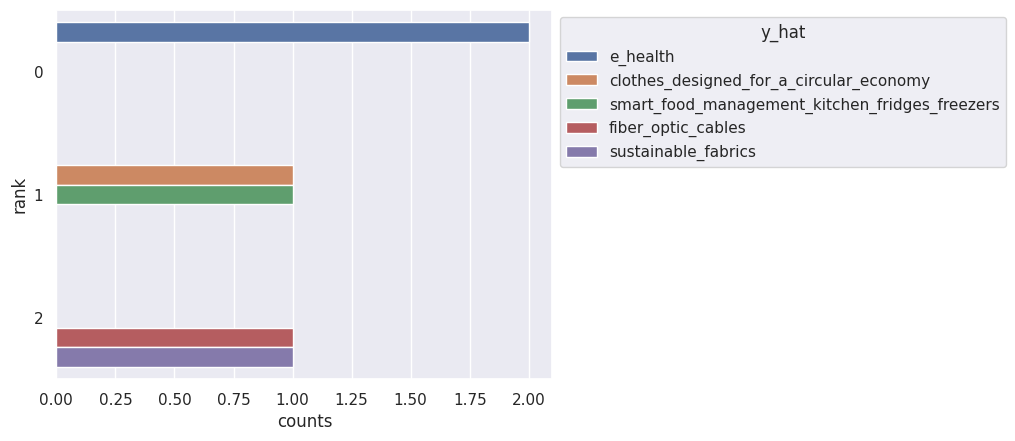

In [68]:
print(f"rank 0 should be '{coi}'")
coi_miss_enhanced_agg = coi_miss_enhanced.groupby(['rank',"y_hat","y_hat_enc"]).size().reset_index(name="counts")
g = sns.barplot(data=coi_miss_enhanced_agg, y="rank", x="counts", hue="y_hat")
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))

#### Inspecting text of non top-k correct classifications

0 : 3d_printed_clothes
1 : artificial_intelligence
2 : autonomous_transport
3 : biking
4 : capsule_wardrobe
5 : car_sharing
6 : cement_production
7 : clothes_designed_for_a_circular_economy
8 : drone
9 : e_health
10 : electric_car
11 : fiber_optic_cables
12 : organic_food
13 : rent_apparel
14 : shipping
15 : smart_food_management_kitchen_fridges_freezers
16 : sustainable_fabrics
Num of non-top-k predictions: 16


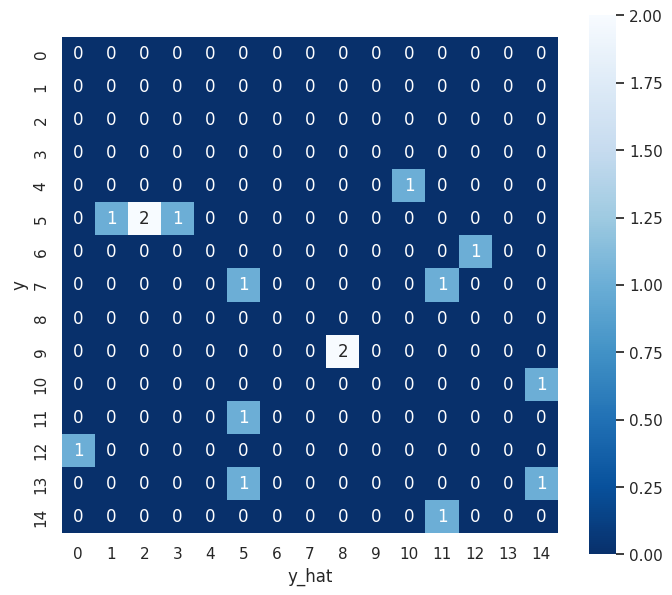

In [69]:
non_top_k = test_predictions.loc[~test_predictions.in_top_k]
#axis_ticks = le.inverse_transform(list(set(list(non_top_k.y_hat_enc.unique()) + list(non_top_k.y_enc.unique()))))
cm = confusion_matrix(non_top_k["y_enc"],non_top_k["y_hat_enc"])
for key,value in le_name_mapping.items():
    print(f"{value} : {key}")
plt.figure(figsize=(8,7))
g = sns.heatmap(cm, annot=True, fmt='g', square = True, cmap = 'Blues_r')
g.set_ylabel("y")
g.set_xlabel("y_hat")
print(f"Num of non-top-k predictions: {len(non_top_k)}")

In [70]:
# subselect worst class
for idx, row in non_top_k.loc[non_top_k.y == "electric_car"].iterrows():
    print(f"[{idx}]")
    print(f"class: {row.y}, predicted: {row.y_hat}")
    print(row.text)
    print("--------------")

[187]
class: electric_car, predicted: e_health
Virtual Fixit Clinic
As COVID-19 unfolds Fixit Clinic is experimenting with “virtual” clinics using teleconferencing software. If you want to try fixing something from home and think remote advice and coaching would be helpful answer these questions:
- Do you have a computer and internet connection that will support video teleconferencing? - Can you show and describe the problem in under five minutes?
--------------
[820]
class: electric_car, predicted: e_health
Do something for our planet, print this page only if needed. Even a small action can make an enormous difference when millions of people do it! Article
The EEA has recently published a new Transport and Environment Reporting Mechanism (TERM) report.
--------------
